# Fish

In [30]:
# 패키지 불러오기
import sys, warnings
# sys.path.append("Y:\Python\Mega_IT")
warnings.filterwarnings('ignore')

# from yjk_module.preprocessing import *
# from yjk_module.ml_module import *
# from yjk_module.dl_module import *

import os
# os.chdir("Y:\Python\Mega_IT\H.Deep_Learning")
# os.getcwd()

# from hossam.util import *
# from hossam.plot import *
# from hossam.tensor import *
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback, History

from kerastuner import Hyperband
from datetime import datetime as dt

In [2]:
# 데이터 불러오기
origin1 = pd.read_excel("./data/fish.xlsx")
origin1.head()

,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


In [5]:
# 스케일링 (MinMax)
# df1 = my_minmax_scaler(data=origin1, yname="무게")

df1 = origin1.copy()
Y = df1.pop('무게')

mm = MinMaxScaler()
df1 = pd.DataFrame(mm.fit_transform(df1), columns = df1.columns)
df1.head()

,길이,높이,두께
0,0.000000,0.000000,0.000000
1,0.148876,0.132834,0.087667
2,0.185393,0.159963,0.151560
3,0.219101,0.231993,0.181278
4,0.252809,0.231993,0.227340


In [6]:
# 훈련 / 검증 데이터 분리 및 shape 추출
# x_train, x_test, y_train, y_test = my_train_test_split(df1, "무게")

x_train, x_test, y_train, y_test = train_test_split(df1, Y, test_size = 0.2, random_state = 0)
rows, cols = x_train.shape

In [7]:
# kears-tuner를 위한 모델 반환 함수 생성
def tf_build(hp) -> Sequential:
    print(type(hp))
    model = Sequential()

    model.add(
        Dense(
            units=hp.Choice("units", values=[32, 64, 128]),
            activation="relu",
            input_shape=(cols,),
        )
    )
    model.add(
        Dense(
            units=hp.Choice("units", values=[16, 32, 64]),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss="mse",
        metrics=["mae"],
    )

    return model

In [8]:
# keras-tuner 객체 생성
tuner = Hyperband(
    hypermodel=tf_build,
    objective="val_mae",
    max_epochs=10,
    factor=3,
    seed=0,
    directory="./tensor_hyperband",
    project_name="tf_hyperband_%s" % dt.now().strftime("%Y%m%d%H%M%S"),
)

tuner

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


2024-04-24 17:18:55.511570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22433 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


In [9]:
%%time

# 최적 하이퍼 파라미터 찾기
tuner.search(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test)
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()

if not best_hps:
    raise ValueError("No best hyperparameters found.")

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps[0].get('units')} and the optimal learning rate for the optimizer
is {best_hps[0].get('learning_rate')}.
"""
)

Trial 9 Complete [00h 00m 01s]
val_mae: 348.6179504394531

Best val_mae So Far: 346.4634704589844
Total elapsed time: 00h 00m 08s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.01.

CPU times: user 7.6 s, sys: 240 ms, total: 7.84 s
Wall time: 8.14 s


<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>
Epoch 1/1000
2/2 [==============================] - 1s 99ms/step - loss: 284019.6250 - mae: 391.3704 - val_loss: 193332.6875 - val_mae: 347.6363
Epoch 2/1000
2/2 [==============================] - 0s 15ms/step - loss: 282889.7188 - mae: 390.3115 - val_loss: 192111.2969 - val_mae: 346.2256
Epoch 3/1000
2/2 [==============================] - 0s 15ms/step - loss: 281340.7500 - mae: 388.7874 - val_loss: 190007.4219 - val_mae: 343.7639
Epoch 4/1000
2/2 [==============================] - 0s 15ms/step - loss: 278565.5312 - mae: 386.1061 - val_loss: 186726.3594 - val_mae: 339.8767
Epoch 5/1000
2/2 [==============================] - 0s 15ms/step - loss: 274522.2812 - mae: 382.0380 - val_loss: 181986.2656 - val_mae: 334.1689
Epoch 6/1000
2/2 [==============================] - 0s 15ms/step - loss: 268056.4062 - mae: 375.8388 - val_loss: 175549.5000 - val_mae: 326.2563
Epoch 7/1000
2/2 [==============================]

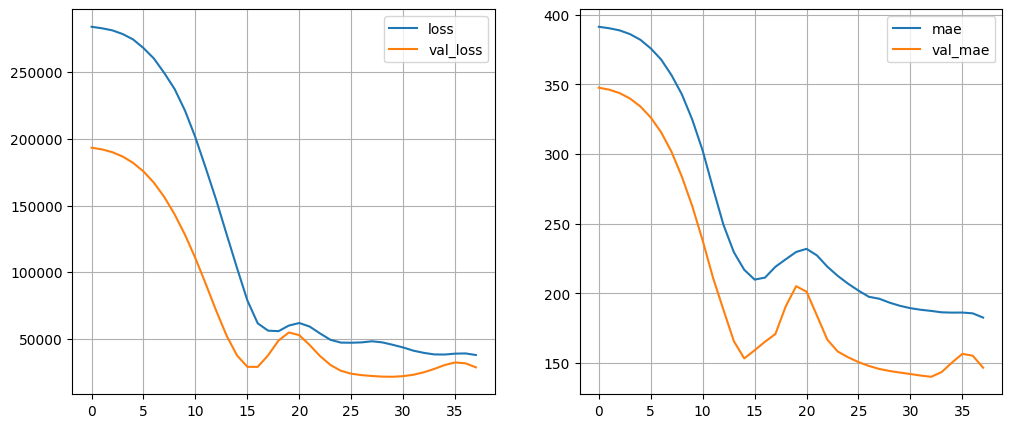

In [21]:
# 최적 모델 성능 확인
model = tuner.hypermodel.build(best_hps[0])
# result = tf_train(model, x_train, y_train, x_test, y_test)
# tf_result(result)

history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1000, callbacks = [
    EarlyStopping(patience = 8, restore_best_weights = True)
])

hist_dict = history.history
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].plot(hist_dict['loss'], label = 'loss')
ax[0].plot(hist_dict['val_loss'], label = 'val_loss')
ax[0].grid()
ax[0].legend()

ax[1].plot(hist_dict['mae'], label = 'mae')
ax[1].plot(hist_dict['val_mae'], label = 'val_mae')
ax[1].grid()
ax[1].legend()

plt.show()

In [22]:
# 다른 모델 구조 사용
def tf_build2(hp) -> Sequential:
    print(type(hp))
    model = Sequential(layers = [
        Dense(units = hp.Choice("units1", values = [32, 64, 128]), activation = 'relu', input_shape = (cols,)),
        Dropout(rate = hp.Choice("dropout1", values = [0.1, 0.15, 0.2])),
        Dense(units = hp.Choice("units2", values = [16, 32, 64]), activation = 'relu', input_shape = (cols,)),
        Dropout(rate = hp.Choice("dropout2", values = [0.1, 0.15, 0.2])),
        Dense(1, activation = "linear")
    ])

    model.compile(optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss="mse",
        metrics=["mae"],)

    return model

In [24]:
# keras-tuner 객체
tuner2 = Hyperband(
    hypermodel=tf_build2,
    objective="val_mae",
    max_epochs=10,
    factor=3,
    seed=0,
    directory="./tensor_hyperband",
    project_name="tf_hyperband_%s" % dt.now().strftime("%Y%m%d%H%M%S"),
)

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [25]:
%%time

# 하이퍼 파라미터 찾기

tuner2.search(
    x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test)
)

# Get the optimal hyperparameters
best_hps2 = tuner2.get_best_hyperparameters()

if not best_hps:
    raise ValueError("No best hyperparameters found.")

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps2[0].get('units1')} and the optimal learning rate for the optimizer
is {best_hps2[0].get('learning_rate')}.
"""
)

Trial 30 Complete [00h 00m 01s]
val_mae: 348.5707092285156

Best val_mae So Far: 313.9770812988281
Total elapsed time: 00h 00m 32s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64 and the optimal learning rate for the optimizer
is 0.01.

CPU times: user 29.1 s, sys: 822 ms, total: 30 s
Wall time: 31.8 s


<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>
Epoch 1/1000
2/2 [==============================] - 1s 103ms/step - loss: 283996.5938 - mae: 391.3659 - val_loss: 193691.1875 - val_mae: 348.0283
Epoch 2/1000
2/2 [==============================] - 0s 15ms/step - loss: 283339.3750 - mae: 390.7704 - val_loss: 193093.0781 - val_mae: 347.3282
Epoch 3/1000
2/2 [==============================] - 0s 15ms/step - loss: 282612.0312 - mae: 390.0371 - val_loss: 192224.1250 - val_mae: 346.3078
Epoch 4/1000
2/2 [==============================] - 0s 15ms/step - loss: 281540.7188 - mae: 388.9729 - val_loss: 191008.9219 - val_mae: 344.8737
Epoch 5/1000
2/2 [==============================] - 0s 15ms/step - loss: 280185.6562 - mae: 387.5425 - val_loss: 189352.2031 - val_mae: 342.9055
Epoch 6/1000
2/2 [==============================] - 0s 15ms/step - loss: 277837.4062 - mae: 385.4143 - val_loss: 187166.0469 - val_mae: 340.2875
Epoch 7/1000
2/2 [==============================

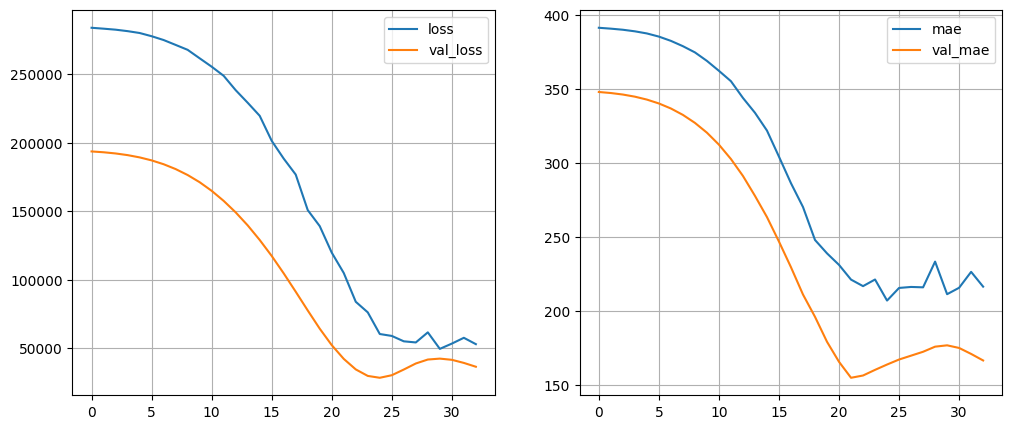

In [26]:
# 모델 성능 확인

model2 = tuner2.hypermodel.build(best_hps2[0])
# result = tf_train(model2, x_train, y_train, x_test, y_test)
# tf_result(result)

history2 = model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1000, callbacks = [
    EarlyStopping(patience = 8, restore_best_weights = True)
])

hist_dict = history2.history
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].plot(hist_dict['loss'], label = 'loss')
ax[0].plot(hist_dict['val_loss'], label = 'val_loss')
ax[0].grid()
ax[0].legend()

ax[1].plot(hist_dict['mae'], label = 'mae')
ax[1].plot(hist_dict['val_mae'], label = 'val_mae')
ax[1].grid()
ax[1].legend()

plt.show()

# Boston 집값 예측

In [27]:
# 데이터 불러오기
origin2 = pd.read_excel("./data/boston.xlsx")
origin2.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [28]:
# 스케일링 (MinMax)
# df2 = my_minmax_scaler(origin2, yname = 'MEDV')
df2 = origin2.copy()

Y = df2.pop('MEDV')

mm = MinMaxScaler()
df2 = pd.DataFrame(mm.fit_transform(df2), columns = df2.columns)

In [29]:
# VIF가 높은 컬럼 삭제
# X = yjk_filter_vif(X, tol = 10)
high_vif = ['TAX', 'AGE', 'B', 'PTRATIO', 'NOX']

df2.drop(high_vif, axis = 1, inplace = True)

In [31]:
# 2차항 추가
# X2 = my_poly_features(X, columns = list(X.columns))

pf = PolynomialFeatures(2, include_bias = False)
df2_poly = pd.DataFrame(pf.fit_transform(df2), columns = pf.get_feature_names_out())
df2_poly.head()

,CRIM,ZN,INDUS,CHAS,RM,DIS,RAD,LSTAT,CRIM^2,CRIM ZN,...,RM^2,RM DIS,RM RAD,RM LSTAT,DIS^2,DIS RAD,DIS LSTAT,RAD^2,RAD LSTAT,LSTAT^2
0,0.000000,0.18,0.067815,0.0,0.577505,0.269203,0.000000,0.089680,0.000000e+00,0.0,...,0.333512,0.155466,0.000000,0.051791,0.072470,0.000000,0.024142,0.000000,0.000000,0.008042
1,0.000236,0.00,0.242302,0.0,0.547998,0.348962,0.043478,0.204470,5.565944e-08,0.0,...,0.300301,0.191230,0.023826,0.112049,0.121774,0.015172,0.071352,0.001890,0.008890,0.041808
2,0.000236,0.00,0.242302,0.0,0.694386,0.348962,0.043478,0.063466,5.555343e-08,0.0,...,0.482172,0.242314,0.030191,0.044070,0.121774,0.015172,0.022147,0.001890,0.002759,0.004028
3,0.000293,0.00,0.063050,0.0,0.658555,0.448545,0.086957,0.033389,8.572933e-08,0.0,...,0.433695,0.295391,0.057266,0.021988,0.201192,0.039004,0.014976,0.007561,0.002903,0.001115
4,0.000705,0.00,0.063050,0.0,0.687105,0.448545,0.086957,0.099338,4.971238e-07,0.0,...,0.472113,0.308197,0.059748,0.068255,0.201192,0.039004,0.044557,0.007561,0.008638,0.009868


In [32]:
# 훈련 / 검증 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(df2_poly, Y, test_size = 0.2, random_state = 0)
_, cols = x_train.shape

In [36]:
# 모델 생성 및 컴파일
model = Sequential([
    Dense(64, activation = 'relu', input_shape = (cols,)),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'linear')
])

# kh = YjkKerasHelper(show_loss = False, show_metrics = False, show_optimizers = False)
# kh.set_strategy(loss = 'mae', metrics = 'mae')
# kh.compile(model)

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mae'])

In [37]:
# 콜백함수 정의
es = EarlyStopping(monitor = 'val_mae', patience = 8, restore_best_weights = True)
re = ReduceLROnPlateau(monitor = 'val_mae', patience = 5, min_lr = 0.00001)

In [38]:
# 모델 훈련
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1000, callbacks = [es, re])

Epoch 1/1000
13/13 [==============================] - 1s 12ms/step - loss: 22.3098 - mae: 22.3098 - val_loss: 21.5509 - val_mae: 21.5509 - lr: 0.0010
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 21.6010 - mae: 21.6010 - val_loss: 20.6710 - val_mae: 20.6710 - lr: 0.0010
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 20.5224 - mae: 20.5224 - val_loss: 19.2245 - val_mae: 19.2245 - lr: 0.0010
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 18.7423 - mae: 18.7423 - val_loss: 17.0004 - val_mae: 17.0004 - lr: 0.0010
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 16.2839 - mae: 16.2839 - val_loss: 14.0485 - val_mae: 14.0485 - lr: 0.0010
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 13.5916 - mae: 13.5916 - val_loss: 11.4903 - val_mae: 11.4903 - lr: 0.0010
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 11.5967 - mae: 11.5967 - val_lo

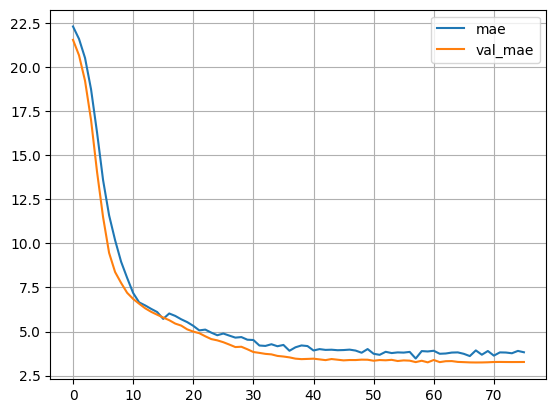

In [39]:
# 학습곡선 확인
# tf_result(history)

hist_dict = history.history

plt.figure()
plt.plot(hist_dict['mae'], label = 'mae')
plt.plot(hist_dict['val_mae'], label = 'val_mae')
plt.grid()
plt.legend()
plt.show()